## Starting Off

Looking at the confusion matrix below, and answer the following questions.  

1. How many oranges are there in the dataset?
2. How many fruits were predicted by the model to be an orange?
3. Of the fruits that were predicted to be an orange, how many were actually mangoes?
4. Of the fruits that are actually mangoes, how many were predicted to be apples?

![alt text](images/confusion_matrix.png)

# Classification Practicum with Class Imbalance

Agenda:
- Review class imbalance
- Review code for different ways to handle class imbalance


In [1]:
#!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics

In [3]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/nyc-mhtn-ds-042219-lectures/master/Module_4/cleaned_titanic.csv', index_col='PassengerId')



In [5]:
titanic.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,youngin,male,Q,S
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0,0


In [6]:
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

# Handling Class Imbalance

## Visualizing Class Imbalance

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


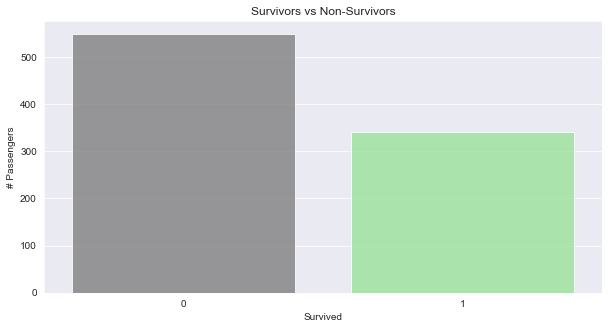

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Survivors vs Non-Survivors')
plt.ylabel('# Passengers')
plt.show()

## Run a Dummy Classifier for Baseline Assessment

In [8]:
1-y.mean()

0.6175478065241844

>This will only predict on one of the classes

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, )

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)




**Questions:**

- What do you think the accuracy score will be for this model?
- What do you think the recall score will be for this model?

>It is 65 because we only predicted 0 even if it was 1

In [10]:

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))

Test Accuracy score:  0.6547085201793722


> It is 0 because we only predicted 0. 

In [11]:
# checking recall
print('Test Recall score: ', recall_score(y_test, dummy_pred))

Test Recall score:  0.0


# Handling Class Imbalance

In this guide, we will cover 5 tactics for handling imbalanced classes in machine learning:

1. Up-sample the minority class
2. Down-sample the majority class
3. Change your performance metric
4. Penalize algorithms (cost-sensitive training)
5. Use tree-based algorithms

## Run a classification Model with class imbalance

Before we start to implement different ways to handle class imbalance, let's fit a basic model to have a better point of comparison.  

In [12]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)

y_pred_test = lr_clf.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.7847533632286996
Test F1 score:  0.6619718309859155


In [13]:
results = {}

results['imbalanced'] = (accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test))

## Prepping data for handling class imbalances

We are goign to change the training dataset to which we fit our model, so we want to bring our training data back together before we make those changes. 

In [14]:
# concatenate our training data back together
training  = pd.concat([X_train, y_train], axis=1)

In [15]:
training

,Pclass,Age,SibSp,Parch,Fare,youngin,male,Q,S,Survived
PassengerId,,,,,,,,,,
740,3,24.0,0,0,7.8958,0,1,0,1,0
148,3,9.0,2,2,34.3750,1,0,0,1,0
876,3,15.0,0,0,7.2250,0,0,0,0,1
641,3,20.0,0,0,7.8542,0,1,0,1,0
885,3,25.0,0,0,7.0500,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
32,1,37.0,1,0,146.5208,0,0,0,0,1
490,3,9.0,1,1,15.9000,1,1,0,1,1
41,3,40.0,1,0,9.4750,0,0,0,1,0


In [16]:
# separate minority and majority classes
deceased = training[training.Survived==0]
survived = training[training.Survived==1]

In [17]:
# Get a class count to understand the class imbalance.
print('deceased count: '+ str(len(deceased)))
print('survived count: '+ str(len(survived)))

deceased count: 403
survived count: 263


## Resampling 
You can change the dataset that you use to build your predictive model to have more balanced data.

This change is called sampling your dataset and there are two main methods that you can use to even-up the classes:

You can add copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or
You can delete instances from the over-represented class, called under-sampling.
These approaches are often very easy to implement and fast to run. They are an excellent starting point.


**Some Rules of Thumb:**
- Consider testing under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)
- Consider testing over-sampling when you don’t have a lot of data (tens of thousands of records or less)
- Consider testing random and non-random (e.g. stratified) sampling schemes.
- Consider testing different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)

![alt text](images/resampling.png)

In [18]:
from sklearn.utils import resample


### Upsampling



In [19]:
# upsample minority
survived_upsampled = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(deceased), # match number in majority class
                          random_state=23) # reproducible results

In [20]:
survived_upsampled.shape

(403, 10)

In [21]:
# combine majority and upsampled minority
upsampled = pd.concat([deceased, survived_upsampled])

# check new class counts
upsampled.Survived.value_counts()

1    403
0    403
Name: Survived, dtype: int64

In [22]:
len(upsampled)

806

Now that we have balanced classes, lets see how this can affect the performance of the model.  

In [23]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Survived
X_train = upsampled.drop('Survived', axis=1)


# upsampled_dt = DecisionTreeClassifier(max_depth=5)
upsampled_lr = LogisticRegression(solver='liblinear')


# upsampled_dt.fit(X_train, y_train)
upsampled_lr.fit(X_train, y_train)


# upsampled_pred = upsampled_dt.predict(X_test)
upsampled_pred = upsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, upsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, upsampled_pred))



Test Accuracy score:  0.7713004484304933
Test F1 score:  0.6577181208053691


In [24]:
results['upsampled'] = (accuracy_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred))

In [25]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691)}

## Downsampling

In [26]:
# downsample majority
survived_downsampled = resample(deceased,
                                replace = False, # sample without replacement
                                n_samples = len(survived), # match minority n
                                random_state = 23) # reproducible results

In [27]:
# combine minority and downsampled majority
downsampled = pd.concat([survived_downsampled, survived])

# checking counts
downsampled.Survived.value_counts()

1    263
0    263
Name: Survived, dtype: int64

In [28]:
# trying logistic regression again with the balanced dataset
y_train = downsampled.Survived
X_train = downsampled.drop('Survived', axis=1)


downsampled_lr = LogisticRegression(solver='liblinear')


downsampled_lr.fit(X_train, y_train)

downsampled_pred = downsampled_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, downsampled_pred))

Test Accuracy score:  0.7802690582959642
Test F1 score:  0.6711409395973155


In [29]:
results['downsampled'] = (accuracy_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred))

In [30]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155)}

## Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![alt text](images/smote.png)

>runs kind of like KNN and the default is 5!

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, )

In [34]:

sm = SMOTE( random_state=23)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [35]:
y_train.value_counts()

1    403
0    403
Name: Survived, dtype: int64

In [36]:
smote_lr = LogisticRegression(solver='liblinear')

In [37]:
# smote_dt.fit(X_train, y_train)
smote_lr.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

In [38]:
smote_pred = smote_lr.predict(X_test)


In [39]:

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.7847533632286996
Test F1 score:  0.68


In [40]:
results['smote'] = (accuracy_score(y_test, smote_pred), f1_score(y_test, smote_pred))

In [41]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7847533632286996, 0.68)}

## Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

> Looks at pairs of opposite classes and removes the majority class. Doesn't make it completely equal. Only removes some of the close encounters.

![alt text](images/tomek.png)

In [42]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE



In [43]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, )

In [44]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 356, 1: 263})


In [45]:
feature_cols

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'youngin', 'male', 'Q', 'S'], dtype='object')

In [46]:
tl.sample_indices_

array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107, 108, 109,
       110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [48]:
# remove Tomek links
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_sample(X_train, y_train)



## Show removed observations

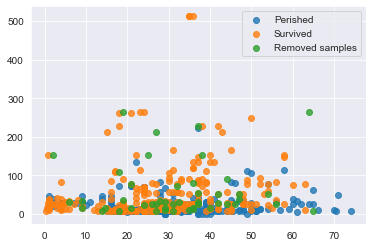

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_train.shape[0]),
                                   tl.sample_indices_)
idx_class_0 = y_resampled == 0
plt.scatter(X_resampled[idx_class_0]['Age'], X_resampled[idx_class_0]['Fare'],
            alpha=.8, label='Perished')
plt.scatter(X_resampled[~idx_class_0]['Age'], X_resampled[~idx_class_0]['Fare'],
            alpha=.8, label='Survived')
plt.scatter(X_train.iloc[idx_samples_removed]['Age'], X_train.iloc[idx_samples_removed]['Fare'],
             alpha=.8, label='Removed samples')
plt.legend()

In [50]:
len(idx_samples_removed)

47

In [51]:
len(X_train)

666

In [52]:
len(X_resampled)

619

In [53]:
tomek_lr = LogisticRegression(solver='liblinear')

tomek_lr.fit(X_resampled, y_resampled)

tomek_pred = tomek_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred))

Test Accuracy score:  0.7982062780269058
Test F1 score:  0.6938775510204082


In [54]:
results['tomek'] = (accuracy_score(y_test, tomek_pred), f1_score(y_test, tomek_pred))

In [55]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7847533632286996, 0.68),
 'tomek': (0.7982062780269058, 0.6938775510204082)}

### Penalize Algorithms (Cost-Sensitive Training)
The next tactic is to use penalized learning algorithms that increase the cost of classification mistakes on the minority class.

During training, we can use the argument `class_weight='balanced'`  to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

In [50]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, )

In [56]:
lr_clf_weighted = LogisticRegression(solver='liblinear', class_weight='balanced')

lr_clf_weighted.fit(X_train, y_train)

y_weighted_test = lr_clf_weighted.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_weighted_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_weighted_test))

Test Accuracy score:  0.7802690582959642
Test F1 score:  0.6711409395973155


In [57]:
results['weighted'] = (accuracy_score(y_test, y_weighted_test), f1_score(y_test, y_weighted_test))

In [58]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7847533632286996, 0.68),
 'tomek': (0.7982062780269058, 0.6938775510204082),
 'weighted': (0.7802690582959642, 0.6711409395973155)}

## Tree-Based Algorithms

Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

>Boosted tree does a better job of not biasing the majority class

In [61]:
# Instantiate the classifier using 200 trees
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 23, n_estimators=200, class_weight='balanced')

In [62]:
#fit the model to the training data
rfc.fit(X_train, y_train)

#use the fitted model to predict on the test data
rfc_pred = rfc.predict(X_test)


# checking accuracy on the test data
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))


# checking accuracy on the test data
print('Test F1 score: ', f1_score(y_test, rfc_pred))

Test Accuracy score:  0.7713004484304933
Test F1 score:  0.6666666666666666


In [63]:
results['rfc'] = (accuracy_score(y_test, rfc_pred), f1_score(y_test, rfc_pred))

In [64]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7847533632286996, 0.68),
 'tomek': (0.7982062780269058, 0.6938775510204082),
 'weighted': (0.7802690582959642, 0.6711409395973155),
 'rfc': (0.7713004484304933, 0.6666666666666666)}

## Change Your Performance Metric

Accuracy is not the metric to use when working with an imbalanced dataset. We have seen that it is misleading.

There are metrics that have been designed to tell you a more truthful story when working with imbalanced classes.

- Precision: A measure of a classifiers exactness.
- Recall: A measure of a classifiers completeness
- F1 Score (or F-score): A weighted average of precision and recall.

- Kappa (or Cohen’s kappa): Classification accuracy normalized by the imbalance of the classes in the data.
- ROC Curves: Like precision and recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance thresholds of these values.

When using a cross-validation method, you can utilize one of these as the scoring metric when comparing across multiple methods.  

This will not change the way a model is fitted, it will just choose a different model as the **best_estimator** based on the scoring metric. 

>When you run LogReg, the cost function will determine the parameters of the model

>When you run GridSearch, it will run all of the different models. You can tell it to look for a specific performance metric.

## Reframe as Anomaly Detection

If your class imbalance is very extreme (less than 0.1%), it might be better to treat this as an anomay detection problem than a classification problem.  
**Anomaly detection**, a.k.a. outlier detection, is for detecting outliers and rare events. Instead of building a classification model, you'd have a "profile" of a normal observation. If a new observation strays too far from that "normal profile," it would be flagged as an anomaly.

https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1